## AlexNet Architecture

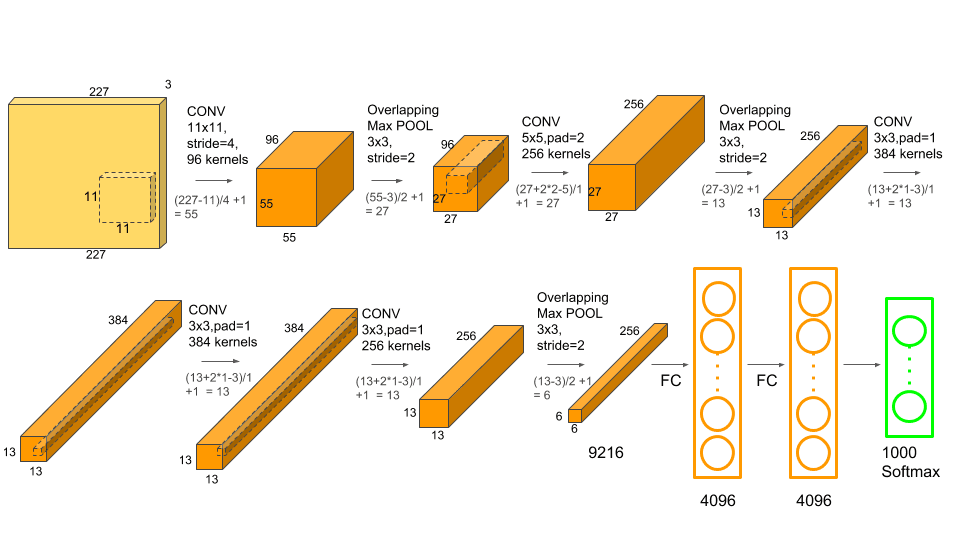

## CIFAR-10 Dataset
The CIFAR-10 dataset is a widely used collection of 60,000 32x32 color images, categorized into 10 classes, commonly used for training and testing image classification models, particularly Convolutional Neural Networks (CNNs). It contains 50,000 training images and 10,000 test images. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.


It consists of 60,000 images in total, with 50,000 for training and 10,000 for testing.


Each image is 32x32 pixels and is in color.


In [22]:
import os
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import sampler
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

In [23]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 90
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
img_transforms=transforms.Compose(
    [
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

In [25]:
train_dataset=datasets.CIFAR10(root='./data',train=True,download=True,transform=img_transforms)
test_dataset=datasets.CIFAR10(root='./data',train=False,download=True,transform=img_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
validation_fraction=0.1
validation_num=int(validation_fraction * len(train_dataset))
train_indices = torch.arange(0, len(train_dataset) - validation_num)
valid_indices = torch.arange(len(train_dataset) - validation_num, len(train_dataset))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [27]:
valid_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=valid_sampler,
                          num_workers=2,
                          pin_memory=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          sampler=train_sampler,
                          num_workers=2,
                          pin_memory=True
                          )

test_loader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                              num_workers=2,
                            pin_memory=True)

In [28]:
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([128, 3, 227, 227])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([9, 4, 5, 3, 2, 8, 9, 0, 0, 9])


In [29]:
class AlexNet(torch.nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.num_classes=num_classes
    self.feature_extractor=torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2),
        torch.nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2),
        torch.nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3,stride=2)
        )
    self.classifier=torch.nn.Sequential(
        torch.nn.Linear(256*6*6,4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(),
        torch.nn.Linear(4096,4096),
        torch.nn.ReLU(),
        torch.nn.Dropout(),
        torch.nn.Linear(4096,10)
    )

  def forward(self,X):
    X=self.feature_extractor(X)
    X=torch.flatten(X,1)
    logits=self.classifier(X)
    return logits

  def compute_accuracy(self,data_loader,device):
    correct_preds=0
    total_preds=0

    for batch_idx,(images,labels) in enumerate(data_loader):
      images=images.to(device)
      labels=labels.to(device)
      logits=self.forward(images)
      probs=F.softmax(logits,dim=1)
      preds=torch.argmax(probs,dim=1)
      correct_preds+=torch.sum(preds==labels)
      total_preds+=labels.size(0)

    accuracy=correct_preds/total_preds
    return accuracy*100


  def train_model(self,num_epochs,train_loader,valid_loader,test_loader,device):
    logging_interval=100
    torch.random.manual_seed(RANDOM_SEED)
    self.to(device)
    optimizer=torch.optim.SGD(self.parameters(),lr=0.01,momentum=0.01,weight_decay=0.005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):
      self.train()

      for batch_idx,(images,labels) in enumerate(train_loader):
        images=images.to(device)
        labels=labels.to(device)
        logits=self.forward(images)
        loss=F.cross_entropy(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())

        if (batch_idx+1) % logging_interval==0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

      self.eval()
      with torch.no_grad():
        train_acc=self.compute_accuracy(train_loader,device)
        valid_acc=self.compute_accuracy(valid_loader,device)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {valid_acc:.2f}%")

        scheduler.step(valid_acc_list[-1])

    test_acc = self.compute_accuracy(test_loader, device=device)
    print(f"Test Accuracy: {test_acc:.2f}%")

    return minibatch_loss_list, train_acc_list, valid_acc_list







In [30]:
model=AlexNet(num_classes=10)

In [31]:
model.train_model(num_epochs=NUM_EPOCHS,train_loader=train_loader,valid_loader=valid_loader,test_loader=test_loader,device=DEVICE)


Epoch: 1/90, Batch: 100/351, Loss: 2.3032
Epoch: 1/90, Batch: 200/351, Loss: 2.3009
Epoch: 1/90, Batch: 300/351, Loss: 2.3007
Epoch: 1/90, Train Accuracy: 15.93%, Validation Accuracy: 15.62%
Epoch: 2/90, Batch: 100/351, Loss: 2.3021
Epoch: 2/90, Batch: 200/351, Loss: 2.3023
Epoch: 2/90, Batch: 300/351, Loss: 2.3016
Epoch: 2/90, Train Accuracy: 12.86%, Validation Accuracy: 12.36%
Epoch: 3/90, Batch: 100/351, Loss: 2.3022
Epoch: 3/90, Batch: 200/351, Loss: 2.3023
Epoch: 3/90, Batch: 300/351, Loss: 2.3012
Epoch: 3/90, Train Accuracy: 17.92%, Validation Accuracy: 17.98%
Epoch: 4/90, Batch: 100/351, Loss: 2.2998
Epoch: 4/90, Batch: 200/351, Loss: 2.2997
Epoch: 4/90, Batch: 300/351, Loss: 2.2985
Epoch: 4/90, Train Accuracy: 17.72%, Validation Accuracy: 17.52%
Epoch: 5/90, Batch: 100/351, Loss: 2.2959
Epoch: 5/90, Batch: 200/351, Loss: 2.2874
Epoch: 5/90, Batch: 300/351, Loss: 2.2586
Epoch: 5/90, Train Accuracy: 20.36%, Validation Accuracy: 20.18%
Epoch: 6/90, Batch: 100/351, Loss: 2.1759
Epo

([2.301051139831543,
  2.3009140491485596,
  2.3023645877838135,
  2.3028531074523926,
  2.302231550216675,
  2.304795742034912,
  2.302030324935913,
  2.303354501724243,
  2.3012521266937256,
  2.303190231323242,
  2.3034608364105225,
  2.302117347717285,
  2.3023085594177246,
  2.3028292655944824,
  2.30157208442688,
  2.3018953800201416,
  2.3018782138824463,
  2.302318572998047,
  2.3023033142089844,
  2.3029701709747314,
  2.302726984024048,
  2.3025994300842285,
  2.3014516830444336,
  2.3021645545959473,
  2.301105499267578,
  2.3040237426757812,
  2.302621603012085,
  2.3024511337280273,
  2.3017876148223877,
  2.3019533157348633,
  2.301784038543701,
  2.30148983001709,
  2.302586793899536,
  2.3031222820281982,
  2.30320143699646,
  2.3023273944854736,
  2.3028759956359863,
  2.301636219024658,
  2.3018813133239746,
  2.3038930892944336,
  2.301741361618042,
  2.3028664588928223,
  2.3030319213867188,
  2.301215410232544,
  2.3012688159942627,
  2.300520420074463,
  2.3022992

## after training for 2-3 hours I realized that I didnt store the losses, So no loss curves for now 😀😀 coz im going to lose my mind fr if i have to train this from scratch once again

In [36]:
from itertools import product


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [37]:
model.compute_accuracy(test_loader,DEVICE)

tensor(77.9300, device='cuda:0')

In [38]:
compute_confusion_matrix(model,test_loader,DEVICE)

array([[828,  14,  31,  19,  16,   7,   5,  10,  57,  13],
       [  9, 875,   2,   9,   3,   3,   9,   1,  23,  66],
       [ 55,   5, 701,  49,  63,  44,  44,  20,  13,   6],
       [ 16,  10,  69, 589,  57, 150,  44,  34,  10,  21],
       [ 17,   1,  61,  53, 751,  30,  27,  48,   5,   7],
       [  8,   1,  43, 153,  44, 678,  13,  36,  13,  11],
       [  4,   3,  31,  44,  27,  21, 850,   2,  14,   4],
       [ 13,   4,  28,  35,  49,  42,   7, 806,   5,  11],
       [ 41,  26,   8,   9,   6,  13,   4,   3, 868,  22],
       [ 19,  60,   5,  22,   2,   8,   5,  10,  22, 847]])

In [39]:
def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

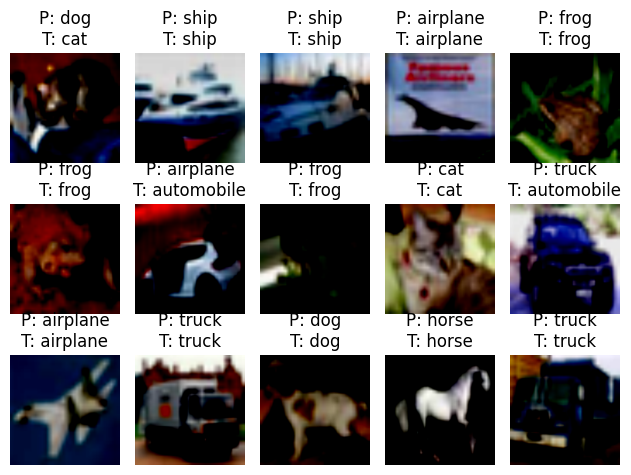

In [41]:
model.cpu()
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, class_dict=class_dict)